In [61]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, execute, Aer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm
import pandas as pd
import json

# Define necessary subroutines

In [62]:
# Define (de-)normalization routines
def norm(mini,maxi,x):
    a = (x+abs(mini))/abs(abs(maxi)+abs(mini))
    return a

def denorm(mini,maxi,z, k_scale):
    c = z*abs(abs(maxi)+abs(mini))
    return c

# Define routine for calculating the corresponding rotation angle
def prob2angle(y):
    b = np.arcsin(np.sqrt(y))
    return b

# normalization for gearbox
def norm_gb(z,maxi,steps,u_f,d_f,S0):
    maxi2 = S0*( u_f**steps - ( u_f*(u_f**steps - 1)/( steps*(u_f-1) ) ))            # geometric sum
    #maxi2 = S0* u_f**steps / 2
    c = (z + maxi2) / (2*maxi2)
    return c

# Addition routine

In [63]:
def adding(nosaaq,nohq,vals):
    
    # Create string to use for formating integer in k-digit binary
    help_string_a = '0' + str(nohq) + 'b'
    
    # Define register
    s = QuantumRegister(nosaaq)
    v = QuantumRegister(nosaaq)
    a = QuantumRegister(nohq)
    g = QuantumRegister(1)

    # Start the circuit    
    qc = QuantumCircuit(s,v,a,g)

    # Uniformly-controlled rotations to store values for addition in respective amplitudes
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(2*val[2])        
        qc.ucry(temp_l, s[-(i+1):][::-1], v[-(i+1)])

    # Prepare ancillary qubits for addition
    qc.h(a)

    # Perform the addition
    for i in range(nosaaq):
        hq_list = [v[i]]
        for p in range(nohq):
            hq_list.append(a[p])

        # Create binary representation for i
        bin_help = format(i, help_string_a)    

        for lll, element in enumerate(bin_help):
            if element == str(1):
                qc.x(a[lll])        

        qc.mcx(hq_list, g[0])

        for jjj, element in enumerate(bin_help):
            if element == str(1):
                qc.x(a[jjj])  

    # Uncompute the ancillary qubits used for addition
    qc.h(a)

    qo = qc.to_gate()
    qo.name = 'ampl. adding'
    return qo

# Single gearbox

In [64]:
def single_gb(nosaaq,vals):
    s = QuantumRegister(nosaaq)
    u = QuantumRegister(2)
    qc = QuantumCircuit(s,u)


    qc.ry(np.pi/2, u[0])
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(-(1/nosaaq)*np.pi*val[3])       
        qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        if i == len(vals)-1:
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(np.pi*val[3])
            qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
                
    qc.cx(u[0],u[1])

    qc.ry(-np.pi/2, u[0])
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append((1/nosaaq)*np.pi*val[3])        
        qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        if i == len(vals)-1:
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(-np.pi*val[3])
            qc.ucry(temp_l, s[-(i+1):][::-1], u[0])
        
    qo = qc.to_gate()
    qo.name = 'gearbox'
    return qo

# Denominator $d_i(x)$

$ \frac{d_0(x)}{2} = 0.91526 $

$ \frac{d_2(x)}{2} = 0.485281 \cos(2x)^2 $

$ \frac{d_4(x)}{2} = 0.0832611 \cos(4x)^2 $

$ \frac{d_6(x)}{2} = 0.0142853 \cos(6x)^2.$

In [65]:
factor0 = 0.91526
factor2 = 0.485281
factor4 = 0.0832611
factor6 = 0.0142853

In [66]:
def denomi(nosaaq, vals, factor, freq):

    s = QuantumRegister(nosaaq, 's')
    ud = QuantumRegister(2, 'u')
    f = QuantumRegister(1, 'final')
    
    
    af = 2*np.arcsin(np.sqrt(factor))
    qc = QuantumCircuit(s,ud,f)
    if freq != 0:
        
        '''
        for i, l_val in enumerate(vals):
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(( freq /nosaaq)*np.pi*val[3])       
            qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])
        '''

        qc.ry(freq*np.pi/2, ud[0])
        for i, l_val in enumerate(vals):
            temp_l = []
            for j, val in enumerate(l_val):
                temp_l.append(-(freq/nosaaq)*np.pi*val[3])       
            qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])
            if i == len(vals)-1:
                temp_l = []
                for j, val in enumerate(l_val):
                    temp_l.append(freq*np.pi*val[3])
                qc.ucry(temp_l, s[-(i+1):][::-1], ud[0])


            
        qc.x(ud[0])

        qc.ry(af, ud[1])

        qc.mcx([ud[0],ud[1]], f[0])
        
    else:
        
        qc.ry(af, ud[1])
        qc.cx(ud[1], f[0])
    
    #print(qc)
    
    qo = qc.to_gate()
    qo.name = 'denominator'+str(freq)
    return qo

# Define the addition tree and other used values

In [67]:
# Set number of steps
steps = 3

shots = 1000 * 1000

# Set addition propteries
S0 = 1
u_f = 1.3
d_f = 0.8
asset_changes = [u_f, d_f]

up1 = S0*u_f
down1 = S0*d_f

# Calculate min/max
maxi = S0 * u_f**steps
mini = 0


# Create nested list where each steps is represented by a list, where each point is represented
# by a list containing the value, the normalized value, and the corresponding rotation angle
orig_list = [[up1,norm(mini,maxi,up1),prob2angle(norm(mini,maxi,up1)),norm_gb(up1,maxi,steps,u_f,d_f,S0)],[down1,norm(mini,maxi,down1),prob2angle(norm(mini,maxi,down1)),norm_gb(down1,maxi,steps,u_f,d_f,S0)]]
vals = []
vals.append(orig_list)

for i in range(steps-1):
    tmp_list = []
    for j in vals[i]:
        for change in asset_changes:
            l = j[0]*change
            tmp_list.append([l,norm(mini,maxi,l),prob2angle(norm(mini,maxi,l)),norm_gb(l,maxi,steps,u_f,d_f,S0)])
    vals.append(tmp_list)    
#print(vals)


# Calculate number of ancillary qubits
nohq = int(np.ceil(np.log2(steps)))

# Compute values needed for timesteps not equal to power of 2
nhat = int(2**nohq)
k_scale = steps / nhat



# Construct the circuit

In [68]:
def buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number):
    # Define circuit elements
    s = QuantumRegister(steps, 'states')
    v = QuantumRegister(steps, 'terms for addition')
    a = QuantumRegister(nohq, 'addition ancillary')
    g = QuantumRegister(1, 'addition result')
    u = QuantumRegister(2, 'gearbox qubits')
    r = QuantumRegister(1, 'add g result')

    ud = QuantumRegister(2, 'denom help')
    df = QuantumRegister(1, 'denom f')
    f = QuantumRegister(1, 'final')
    cr = ClassicalRegister(2, 'bits')

    # Define circuit subroutines
    add_circ = adding(steps,nohq,vals)
    gearbox = single_gb(steps,vals)
    #rescaler = rescale(mini,maxi,k_scale)
    
    if denominator_number == 0:
        denominator = denomi(steps,vals,factor0,0)
    elif denominator_number == 2:
        denominator = denomi(steps,vals,factor2,2)
    elif denominator_number == 4:
        denominator = denomi(steps,vals,factor4,4)
    elif denominator_number == 6:
        denominator = denomi(steps,vals,factor6,6)
    else:
        sys.exit()
        
    # Initiate circuit
    qc = QuantumCircuit(s,v,a,g,u,r,ud,df,f,cr)

    # Complete the circuit
    qc.h(s)
    qc.append(add_circ, s[:]+v[:]+a[:]+g[:])
    qc.append(gearbox, s[:]+u[:])
    qc.ccx(g[0],u[1],r[0])
    #qc.append(rescaler, [u[1],r[0]])
    qc.barrier()
    qc.append(denominator, s[:]+ud[:]+df[:])    
    qc.barrier()
    qc.ccx(r[0],df[0],f[0])
    qc.measure((u[0],f[0]),cr)
    
    return qc

In [69]:
def adding_forSubtraction(nosaaq,nohq,vals):
    
    # Create string to use for formating integer in k-digit binary
    help_string_a = '0' + str(nohq) + 'b'
    
    # Define register
    s = QuantumRegister(nosaaq)
    g = QuantumRegister(1)

    # Start the circuit    
    qc = QuantumCircuit(s,g)

    # Uniformly-controlled rotations to store values
    for i, l_val in enumerate(vals):
        temp_l = []
        for j, val in enumerate(l_val):
            temp_l.append(2*val[2])        
        qc.ucry(temp_l, s[:][::-1], g[0])

    qo = qc.to_gate()
    qo.name = 'ampl. adding'
    return qo

def buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number):
    # Define circuit elements
    s = QuantumRegister(steps, 'states')
    g = QuantumRegister(1, 'addition result')
    u = QuantumRegister(2, 'gearbox qubits')
    r = QuantumRegister(1, 'add g result')

    ud = QuantumRegister(2, 'denom help')
    df = QuantumRegister(1, 'denom f')
    f = QuantumRegister(1, 'final')
    cr = ClassicalRegister(2, 'bits')

    # Define circuit subroutines
    add_circ = adding_forSubtraction(steps,nohq,vals[-1:])
    gearbox = single_gb(steps,vals)
    #rescaler = rescale(mini,maxi,k_scale)
    
    if denominator_number == 0:
        denominator = denomi(steps,vals,factor0,0)
    elif denominator_number == 2:
        denominator = denomi(steps,vals,factor2,2)
    elif denominator_number == 4:
        denominator = denomi(steps,vals,factor4,4)
    elif denominator_number == 6:
        denominator = denomi(steps,vals,factor6,6)
    else:
        sys.exit()
        
    # Initiate circuit
    qc = QuantumCircuit(s,g,u,r,ud,df,f,cr)

    # Complete the circuit
    qc.h(s)
    qc.append(add_circ, s[:]+g[:])
    qc.append(gearbox, s[:]+u[:])
    qc.ccx(g[0],u[1],r[0])
    #qc.append(rescaler, [u[1],r[0]])
    qc.barrier()
    qc.append(denominator, s[:]+ud[:]+df[:])    
    qc.barrier()
    qc.ccx(r[0],df[0],f[0])
    qc.measure((u[0],f[0]),cr)
    
    return qc

# Calculate the exact result numerically 

In [70]:
# Create string to use for formating integer in k-digit binary
help_string_a = '0' + str(steps) + 'b'

# Loop over all paths
num_aver_max = 0
for i in range(2**steps):

    # Create binary representation of path index i
    bin_help = format(i, help_string_a)
    
    # Calculate exact result numerically
    numeric = 0
    num_max = 0
    for d in range(0,len(bin_help),1):
        h_summi = 1
        for ele in range(d+1):
            if bin_help[ele] == '0':
                h_summi *= u_f
            else:
                h_summi *= d_f
        numeric += h_summi
    numeric /= len(bin_help)
    numeric = h_summi - numeric
    num_max = max(0,numeric)    
    num_aver_max += num_max
    
num_aver_max /= (2**steps)

exact = num_aver_max
print('Exact =', exact)

Exact = 0.11900000000000004


# Run algorithm and print/save data

$
d(x) := 0.91526 - 0.485281 \cos(2x)^2 + 0.0832611 \cos(4x)^2 - 0.0142853 \cos(6x)^2
$

In [71]:
# Execute the circuit
iterations = 100

qc0 = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=0)
qc2 = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=2)
qc4 = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=4)
qc6 = buildCircuit(steps,vals,k_scale,mini,maxi,denominator_number=6)

qc0_s = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=0)
qc2_s = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=2)
qc4_s = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=4)
qc6_s = buildCircuit_forSubtraction(steps,vals,k_scale,mini,maxi,denominator_number=6)


backend = Aer.get_backend('qasm_simulator')
average = 0
diff_av = 0
fin_list = []

# Open output file
import datetime
date = datetime.datetime.now().strftime("%Hh%Mm%Ss_%d%m%Y")
filename = f'asian_option_doubleGB_individual_results_{steps}steps_{shots}shots_{date}.dat'
with open(filename, 'w') as file:
    
    # Print header
    print('Circuit\t\tDifference')
    print('Circuit, difference w.r.t exact', file=file)
    file.flush()
    
    for i in range(iterations):
        
        # FIRST PART
        counts0 = execute(qc0,backend=backend,shots=shots).result().get_counts()
        result0 = counts0.get('10',0)/shots

        counts2 = execute(qc2,backend=backend,shots=shots).result().get_counts()
        result2 = counts2.get('10',0)/shots

        counts4 = execute(qc4,backend=backend,shots=shots).result().get_counts()
        result4 = counts4.get('10',0)/shots

        counts6 = execute(qc6,backend=backend,shots=shots).result().get_counts()
        result6 = counts6.get('10',0)/shots

        # SECOND PART
        counts0_s = execute(qc0_s,backend=backend,shots=shots).result().get_counts()
        result0_s = counts0_s.get('10',0)/shots

        counts2_s = execute(qc2_s,backend=backend,shots=shots).result().get_counts()
        result2_s = counts2_s.get('10',0)/shots

        counts4_s = execute(qc4_s,backend=backend,shots=shots).result().get_counts()
        result4_s = counts4_s.get('10',0)/shots

        counts6_s = execute(qc6_s,backend=backend,shots=shots).result().get_counts()
        result6_s = counts6_s.get('10',0)/shots
        


        res = {
            'result_ST_0': result0_s,
            'result_ST_2': result2_s,
            'result_ST_4': result4_s,
            'result_ST_6': result6_s,
            'result_mean_0': result0,
            'result_mean_2': result2,
            'result_mean_4': result4,
            'result_mean_6': result6,
        }

        result = (result0_s - result2_s + result4_s - result6_s) - (1/k_scale)*(result0 - result2 + result4 - result6)
        

        fin = denorm(mini,maxi,2*result,k_scale)
        

        fin_list.append(fin)
        average += fin
        diff = abs(fin-exact)
        diff_av += diff
        print(f'{round(fin,4)}\t\t{round(diff,4)}')
        print(fin,diff, file=file)
        file.flush()
    average /= iterations
    diff_av /= iterations
    print('__________________________________')
    print(f'{round(average,4)}\t\t{round(diff_av,4)}')
    print('', file=file)
    print(average,diff_av, file=file)
    print('StDev:', np.std(fin_list)*100, '%')

Circuit		Difference
0.1102		0.0088
0.1051		0.0139
0.1132		0.0058
0.1077		0.0113
0.1037		0.0153
0.1064		0.0126
0.1078		0.0112
0.1063		0.0127
0.1055		0.0135
0.109		0.01
0.1054		0.0136
0.1097		0.0093
0.1016		0.0174
0.1041		0.0149
0.1042		0.0148
0.1056		0.0134
0.099		0.02
0.0994		0.0196
0.1014		0.0176
0.1065		0.0125
0.1048		0.0142
0.1004		0.0186
0.1049		0.0141
0.1089		0.0101
0.1021		0.0169
0.1081		0.0109
0.1029		0.0161
0.1025		0.0165
0.111		0.008
0.1045		0.0145
0.1105		0.0085
0.1066		0.0124
0.1039		0.0151
0.1105		0.0085
0.108		0.011
0.1038		0.0152
0.1038		0.0152
0.1022		0.0168
0.1013		0.0177
0.107		0.012
0.1074		0.0116
0.1019		0.0171
0.1083		0.0107
0.1088		0.0102
0.109		0.01
0.0989		0.0201
0.1045		0.0145
0.1034		0.0156
0.1071		0.0119
0.1056		0.0134
0.1002		0.0188
0.1092		0.0098
0.1044		0.0146
0.107		0.012
0.1022		0.0168
0.1047		0.0143
0.1074		0.0116
0.1096		0.0094
0.1069		0.0121
0.1081		0.0109
0.1006		0.0184
0.1081		0.0109
0.103		0.016
0.1079		0.0111
0.1077		0.0113
0.1049		0.0141
0.1053		0

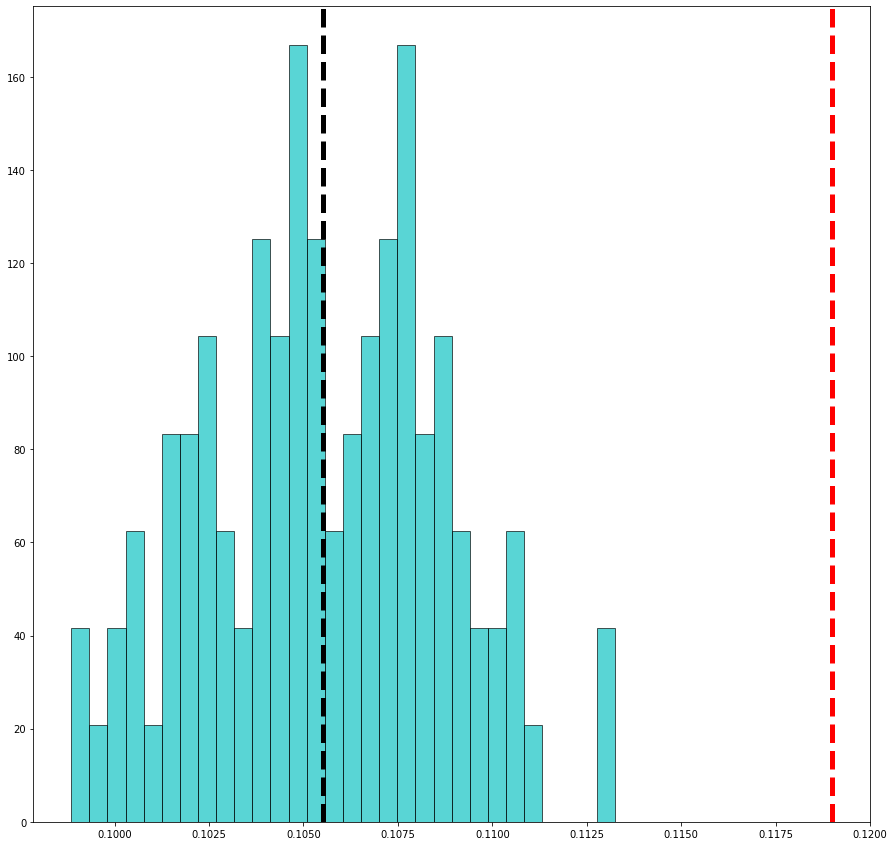

In [87]:
plt.figure(figsize=(15,15))
plt.hist(fin_list, bins=30, color='c', edgecolor='k', alpha=0.65, density=True)
plt.axvline(np.mean(fin_list), color='k', linestyle='dashed', linewidth=5)
plt.axvline(exact, color='r', linestyle='dashed', linewidth=5)
plt.show()

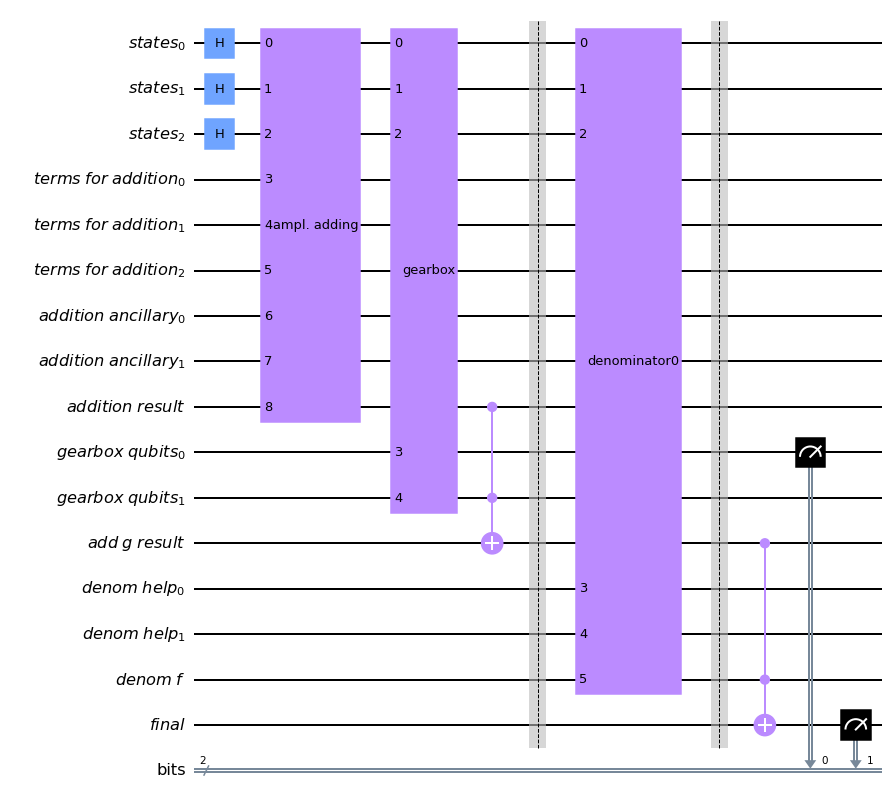

In [73]:
qc0.draw(output='mpl')
#qc1.decompose().draw(output='mpl')

In [76]:
import datetime
date = datetime.datetime.now().strftime("%Hh%Mm%Ss_%d%m%Y")
file = 'asian_option_singleGB_direct_results_'+str(steps)+'steps_'+str(shots)+'shots_'+str(date)+'.json'
with open(file, 'w', encoding='utf-8') as f: json.dump(fin_list, f, ensure_ascii=False, indent=4)